In [1]:
import sys,os
import datetime 
import warnings
import subprocess
import numpy        as np
import pandas       as pd
import xarray       as xr
print('Library have loaded!')

Library have loaded!


In [2]:
## Information of path and loop index
path_obs_monthly  = '/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/OBS/regrid_monthly/'
path_cwrf_hindcast= '/scratch16/umd-xliang/shinsa11/Exp2023Dec_NonBC/CWRF-post/'
path_climatology  = '/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/cwrf_operational/climatology/'
path_operational  = '/scratch16/umd-xliang/aditya/cwrf_operational/CWRF-post/V0/'
path_adjustment   = '/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/CWRF_v0_adjustment/'
static_path       = '/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/static/'
MASK_US           = xr.open_dataset(f'{static_path}US_MASK_logic.nc')['MASK']


var_names         = ['T2MAX','T2MIN','PRAVG']
years             = range(2012,2023+1)
months            = range(1,12+1)
exps              = ['00','02']


# days that CWRF hindcast runs for each month. It is the right one.
days_per_month    = {
    1: [ 1, 6,11,16,21,26,31],
    2: [ 5,10,15,20,25],
    3: [ 2, 7,12,17,22,27],
    4: [ 1, 6,11,16,21,26],
    5: [ 1, 6,11,16,21,26,31],
    6: [ 5,10,15,20,25,30],
    7: [ 5,10,15,20,25,30],
    8: [ 4, 9,14,19,24,29],
    9: [ 3, 8,13,18,23,28],
    10:[ 3, 8,13,18,23,28],
    11:[ 2, 7,12,17,22,27],
    12:[ 2, 7,12,17,22,27],
}

month_to_delete   = {
    1:[8,9,10,11,12],
    2:[9,10,11,12, 1],
    3:[10,11,12, 1, 2],
    4:[11,12,1, 2, 3],
    5:[12,1,2, 3, 4],
    6:[1,2,3, 4, 5],
    7:[2,3,4, 5, 6],
    8:[3,4,5, 6, 7],
    9:[4,5,6, 7, 8],
    10:[5,6,7,8, 9],
    11:[6,7,8,9,10],
    12:[7,8,9,10,11],
}


In [8]:
break
## Calculate the climatology of Observation
for var_name in var_names:
    list_files = []
    for year in years:
        file_name = f'{path_obs_monthly}OBS_monthly_{var_name}_{year}-01-01-00_{year}-12-31-18.nc'
        if os.path.exists(file_name):
            list_files.append(file_name)
    obs_ds = xr.open_mfdataset(list_files )
    if 'crs' in obs_ds.dims:
        obs_ds    = obs_ds.drop_vars('crs')
    obs_climatology = obs_ds.groupby('time.month').mean(dim='time')
    obs_climatology.to_netcdf(f'{path_climatology}OBS/OBS_climatology_{var_name}_{years[0]}-{years[-1]}.nc')

In [27]:
break
## Calculate the climatology of CWRF
for var_name in var_names:
    for month in months:
        days     = days_per_month[month]
        for day  in days:
            for exp in exps:
                list_files = []
                for year in years:
                    file_name = f'{path_cwrf_hindcast}{year}{month:02}{day:02}_icbc01_exp{exp}_{var_name}_daily.nc'
                    if os.path.exists(file_name):
                        list_files.append(file_name)
                cwrf_ds = xr.open_mfdataset(list_files )

                if 'bottom_top' in cwrf_ds.dims:
                    cwrf_ds    = cwrf_ds.squeeze('bottom_top',drop=True)
                cwrf_climatology = cwrf_ds.groupby('time.month').mean(dim='time')
                filtered_climatology = cwrf_climatology.sel(month=~cwrf_climatology.month.isin(month_to_delete[month]))
                filtered_climatology.to_netcdf(f'{path_climatology}CWRF/CWRF_exp{exp}_climatology_{var_name}_{years[0]}-{years[-1]}_{month:02}{day:02}.nc')

In [6]:
## Adjust the 2024 CWRF simulations

month = 2
for var_name in var_names[0:2]:
    # Read the climatology of observation
    obs_cli = xr.open_dataset(f'{path_climatology}OBS/OBS_climatology_{var_name}_{years[0]}-{years[-1]}.nc')
    days = days_per_month[month]
    for day in days[0:3]:
        for exp in exps:
            # Read the climatology of CWRF
            cwrf_cli = xr.open_dataset(f'{path_climatology}CWRF/CWRF_exp{exp}_climatology_{var_name}_{years[0]}-{years[-1]}_{month:02}{day:02}.nc')
            
            # Read the CWRF data
            cwrf_ds = xr.open_dataset(f'{path_operational}2024{month:02}{day:02}_icbc01_exp{exp}_{var_name}_daily.nc')
            
            # Create an empty dataset to store the adjusted data
            adjusted_ds = cwrf_ds.copy(deep=True)
            adjusted_ds[var_name].values[:] = np.nan  # Initialize with NaNs
            
            # Loop through each month in the CWRF dataset to apply adjustment
            for m in np.unique(cwrf_ds['time'].dt.month.values[:-1]):
                # Find the adjustment for the month
                Adjustment = obs_cli[var_name].sel(month=m) - cwrf_cli[var_name].sel(month=m)
                
                # Apply the adjustment for the specific month
                mask = cwrf_ds['time'].dt.month == m
                adjusted_ds[var_name].loc[{'time': mask}] = cwrf_ds[var_name].loc[{'time': mask}] + Adjustment
                
            # Drop the 'month' coordinate if it's no longer needed
            adjusted_ds = adjusted_ds.drop_vars('month', errors='ignore')
            adjusted_ds = xr.where(MASK_US, adjusted_ds, cwrf_ds)
            adjusted_ds = adjusted_ds.transpose('time', 'bottom_top', 'south_north', 'west_east')
            adjusted_ds[var_name].loc[{'time':cwrf_ds['time'][-1] }] = cwrf_ds[var_name].loc[{'time': cwrf_ds['time'][-1] }]
            adjusted_ds.to_netcdf(f'{path_adjustment}2024{month:02}{day:02}_icbc01_exp{exp}_{var_name}_daily.nc')


In [12]:
# calcualte the ensemble
def ensemble_mean_adjusted(path_adjustment,raw_init_date,var_name):
    ds1 = xr.open_dataset(f'{path_adjustment}{raw_init_date}_icbc01_exp00_{var_name}_daily.nc').expand_dims(exp=['00'])
    ds2 = xr.open_dataset(f'{path_adjustment}{raw_init_date}_icbc01_exp00_{var_name}_daily.nc').expand_dims(exp=['02'])
    ens = xr.concat([ds1,ds2],dim='exp').mean(dim='exp')
    ens.to_netcdf(f'{path_adjustment}{raw_init_date}_icbc01_ensemble_mean_{var_name}_daily.nc')
    
def ensemble_mean_no_adj(path_operational,path_adjustment,raw_init_date,var_name):
    ds1 = xr.open_dataset(f'{path_operational}{raw_init_date}_icbc01_exp00_{var_name}_daily.nc').expand_dims(exp=['00'])
    ds2 = xr.open_dataset(f'{path_operational}{raw_init_date}_icbc01_exp00_{var_name}_daily.nc').expand_dims(exp=['02'])
    ens = xr.concat([ds1,ds2],dim='exp').mean(dim='exp')
    if var_name not in ['T2MAX', 'T2MIN']:
        ens.to_netcdf(f'{path_adjustment}{raw_init_date}_icbc01_ensemble_mean_{var_name}_daily.nc')
    else:
        ens.to_netcdf(f'{path_adjustment}{raw_init_date}_icbc01_ensemble_mean_{var_name}_daily_no_adj.nc')
    
raw_init_dates = ['20240101','20240106','20240111','20240116','20240121','20240126','20240131','20240205','20240210','20240215']
vnames = ['AGHT_PL','AQ2M','ASNOW','ASNOWH','AT2M','ATSK','AU_PL','AV_PL','AXTSS','AXWICE','AXWLIQ','PSFC','RH','uv_10','T2MAX','T2MIN','PRAVG']


# for var_name in var_names[0:2]:
#     for raw_init_date in raw_init_dates:
#         ensemble_mean_adjusted(path_adjustment,raw_init_date,var_name)
        
for var_name in vnames[14:17]:
    for raw_init_date in raw_init_dates:
        try:
            ensemble_mean_no_adj(path_operational,path_adjustment,raw_init_date,var_name)
        except:
            print('error happen')
        

In [56]:
#### Transfer to DAWN, Run on dawn server
   
# Make new forders for each simulation
raw_init_dates = ['20240101','20240106','20240111','20240116','20240121','20240126','20240131','20240205','20240210','20240215']
user_server   = 'guangwei@129.2.80.228'
path_cwrf_raw = '/scratch16/umd-xliang/aditya/cwrf_operational/CWRF-post/'

for raw_init_date in raw_init_dates:
    # command = f'scp umd-gwli@login.rockfish.jhu.edu:/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/CWRF_v0_adjustment/{raw_init_date}* /mnt/gfs01/PUB/S2S/V2023-07/Operational/{raw_init_date}/'
    # subprocess.run(command, shell=True)

# Transfer CWRF raw data to dawn server
for raw_init_date in raw_init_dates:
    command = f'scp umd-gwli@login.rockfish.jhu.edu:/scratch16/umd-xliang/aditya/cwrf_operational/CWRF-post/V0/{raw_init_date}* /mnt/gfs01/PUB/S2S/V2023-07/Operational/{raw_init_date}/'
    subprocess.run(command, shell=True)

# Transfer CWRF ensemble data to dawn server
for raw_init_date in raw_init_dates:
    command = f'scp umd-gwli@login.rockfish.jhu.edu:/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/CWRF_v0_adjustment/{raw_init_date}*  /mnt/gfs01/PUB/S2S/V2023-07/Operational/{raw_init_date}/'
    subprocess.run(command, shell=True)
    
# os.system(f'scp -P 2322 {path_cwrf_raw}{raw_init_date}_icbc01_exp*_*_*.nc  {user_server}:{path_dawn}{raw_init_date}/')



Command executed successfully!
Command executed successfully!
Command executed successfully!



KeyboardInterrupt



In [5]:
#### adjust the 2023 simulation of T2MAX and T2MIN 
path_5day   = '/scratch16/umd-xliang/shinsa11/Exp2023Dec_NonBC/CWRF-post/'
for month  in [10,11,12]:
    for var_name in var_names[0:2]:
        # Read the climatology of observation
        obs_cli = xr.open_dataset(f'{path_climatology}OBS/OBS_climatology_{var_name}_{years[0]}-{years[-1]}.nc')

        days = days_per_month[month]
        for day in days:
            for exp in exps:
                # Read the climatology of CWRF
                cwrf_cli = xr.open_dataset(f'{path_climatology}CWRF/CWRF_exp{exp}_climatology_{var_name}_{years[0]}-{years[-1]}_{month:02}{day:02}.nc')

                # Read the CWRF data
                cwrf_ds = xr.open_dataset(f'{path_5day}2023{month:02}{day:02}_icbc01_exp{exp}_{var_name}_daily.nc')

                # Create an empty dataset to store the adjusted data
                adjusted_ds = cwrf_ds.copy(deep=True)
                adjusted_ds[var_name].values[:] = np.nan  # Initialize with NaNs

                # Loop through each month in the CWRF dataset to apply adjustment
                for m in np.unique(cwrf_ds['time'].dt.month.values[:-1]):
                    # Find the adjustment for the month
                    Adjustment = obs_cli[var_name].sel(month=m) - cwrf_cli[var_name].sel(month=m)

                    # Apply the adjustment for the specific month
                    mask = cwrf_ds['time'].dt.month == m
                    adjusted_ds[var_name].loc[{'time': mask}] = cwrf_ds[var_name].loc[{'time': mask}] + Adjustment

                # Drop the 'month' coordinate if it's no longer needed
                adjusted_ds = adjusted_ds.drop_vars('month', errors='ignore')
                adjusted_ds = xr.where(MASK_US, adjusted_ds, cwrf_ds)
                adjusted_ds = adjusted_ds.transpose('time', 'bottom_top', 'south_north', 'west_east')
                adjusted_ds[var_name].loc[{'time':cwrf_ds['time'][-1] }] = cwrf_ds[var_name].loc[{'time': cwrf_ds['time'][-1] }]
                adjusted_ds.to_netcdf(f'{path_adjustment}2023{month:02}{day:02}_icbc01_exp{exp}_{var_name}_daily.nc')


In [11]:
# calcualte the ensemble
def ensemble_mean_adjusted(path_adjustment,raw_init_date,var_name):
    ds1 = xr.open_dataset(f'{path_adjustment}{raw_init_date}_icbc01_exp00_{var_name}_daily.nc').expand_dims(exp=['00'])
    ds2 = xr.open_dataset(f'{path_adjustment}{raw_init_date}_icbc01_exp00_{var_name}_daily.nc').expand_dims(exp=['02'])
    ens = xr.concat([ds1,ds2],dim='exp').mean(dim='exp')
    ens.to_netcdf(f'{path_adjustment}{raw_init_date}_icbc01_ensemble_mean_{var_name}_daily.nc')
    
def ensemble_mean_no_adj(path_operational,path_adjustment,raw_init_date,var_name):
    ds1 = xr.open_dataset(f'{path_operational}{raw_init_date}_icbc01_exp00_{var_name}_daily.nc').expand_dims(exp=['00'])
    ds2 = xr.open_dataset(f'{path_operational}{raw_init_date}_icbc01_exp00_{var_name}_daily.nc').expand_dims(exp=['02'])
    ens = xr.concat([ds1,ds2],dim='exp').mean(dim='exp')
    if var_name not in ['T2MAX', 'T2MIN']:
        ens.to_netcdf(f'{path_adjustment}{raw_init_date}_icbc01_ensemble_mean_{var_name}_daily.nc')
    else:
        ens.to_netcdf(f'{path_adjustment}{raw_init_date}_icbc01_ensemble_mean_{var_name}_daily_no_adj.nc')
    
raw_init_dates = ['20231008','20231013','20231018','20231023','20231028','20231102','20231107','20231112','20231117','20231122','20231127','20231202','20231207','20231212','20231217','20231222','20231227']
vnames         = ['AGHT_PL','AQ2M','ASNOW','ASNOWH','AT2M','ATSK','AU_PL','AV_PL','AXTSS','AXWICE','AXWLIQ','PSFC','RH','uv_10','T2MAX','T2MIN','PRAVG']


# for var_name in var_names[0:2]:
#     for raw_init_date in raw_init_dates:
#         ensemble_mean_adjusted(path_adjustment,raw_init_date,var_name)
        
for var_name in vnames[14:17]:
    for raw_init_date in raw_init_dates:
        try:
            ensemble_mean_no_adj(path_5day,path_adjustment,raw_init_date,var_name)
        except:
            print('error happen')
        

In [ ]:
# Transfer 2023 data to DAWN server.
import sys,os
import datetime
import subprocess


raw_init_dates = ['20231008','20231013','20231018','20231023','20231028','20231102','20231107','20231112','20231117','20231122','20231127','20231202','20231207','20231212','20231217','20231222','20231227']
user_server    = 'guangwei@129.2.80.228'

# Transfer CWRF raw data to dawn server
for raw_init_date in raw_init_dates:
    command = f'scp umd-gwli@login.rockfish.jhu.edu:/scratch16/umd-xliang/shinsa11/Exp2023Dec_NonBC/CWRF-post/{raw_init_date}* /mnt/gfs01/PUB/S2S/V2023-07/Operational/{raw_init_date}/'
    subprocess.run(command, shell=True)

# Transfer CWRF ensemble data to dawn server
for raw_init_date in raw_init_dates:
    command = f'scp umd-gwli@login.rockfish.jhu.edu:/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/CWRF_v0_adjustment/{raw_init_date}*  /mnt/gfs01/PUB/S2S/V2023-07/Operational/{raw_init_date}/'    
    subprocess.run(command, shell=True)

    
    
# Make new forders for each simulation
for raw_init_date in raw_init_dates:
    command = f'mkdir  {raw_init_date}'
    subprocess.run(command, shell=True)
    
    
    

In [ ]:
import sys,os
import datetime
import subprocess


user_server    = 'guangwei@129.2.80.228'

raw_init_dates = ['20231008','20231013','20231018','20231023','20231028','20231102','20231107','20231112','20231117','20231122','20231127','20231202','20231207','20231212','20231217','20231222','20231227']
raw_init_dates = ['20240101','20240106','20240111','20240116','20240121','20240126','20240131','20240205','20240210','20240215']

raw_init_dates = ['20231008','20231013','20231018','20231023','20231028','20231102','20231107','20231112','20231117','20231122','20231127','20231202','20231207','20231212','20231217','20231222','20231227','20240101','20240106','20240111','20240116','20240121','20240126','20240131','20240205','20240210','20240215']
for raw_init_date in raw_init_dates:
    command = f'rm  {raw_init_date}/*T2MAX*'
    subprocess.run(command, shell=True)
    command = f'rm  {raw_init_date}/*T2MIN*'
    subprocess.run(command, shell=True)

    

for raw_init_date in raw_init_dates:
    command = f'scp umd-gwli@login.rockfish.jhu.edu:/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/CWRF_v0_adjustment/{raw_init_date}*T2MAX*  /mnt/gfs01/PUB/S2S/V2023-07/Operational/{raw_init_date}/'    
    subprocess.run(command, shell=True)
    command = f'scp umd-gwli@login.rockfish.jhu.edu:/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/CWRF_v0_adjustment/{raw_init_date}*T2MIN*  /mnt/gfs01/PUB/S2S/V2023-07/Operational/{raw_init_date}/'    
    subprocess.run(command, shell=True)



In [4]:
# basic Evaluation
CWRF0 = xr.open_dataset(f'{path_adjustment}20240215_icbc01_exp00_T2MAX_daily.nc')
CWRF2 = xr.open_dataset(f'{path_adjustment}20240215_icbc01_exp02_T2MAX_daily.nc')
CWRF0

<xarray.Dataset>
Dimensions:  (time: 198, bottom_top: 1, south_north: 138, west_east: 195)
Coordinates:
  * time     (time) datetime64[ns] 2024-02-17 2024-02-18 ... 2024-09-01
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    T2MAX    (time, bottom_top, south_north, west_east) float32 ...
    lat      (south_north, west_east) float32 ...
    lon      (south_north, west_east) float32 ...

In [33]:
avg0 = CWRF0.groupby('time.month').mean(dim='time').squeeze('bottom_top',drop=True)
avg2 = CWRF2.groupby('time.month').mean(dim='time').squeeze('bottom_top',drop=True)
diff = avg0 - avg2
data = avg2.mean(dim=['south_north','west_east'])['T2MAX']
data

<xarray.DataArray 'T2MAX' (month: 8)>
array([283.97736,       nan,       nan,       nan,       nan,       nan,
             nan,       nan], dtype=float32)
Coordinates:
  * month    (month) int64 2 3 4 5 6 7 8 9

In [25]:
CWRF2 = xr.open_dataset(f'{path_adjustment}20240101_icbc01_exp00_T2MAX_daily.nc')
data = CWRF2.mean(dim=['south_north','west_east'])['T2MAX']
data

<xarray.DataArray 'T2MAX' (time: 212, bottom_top: 1)>
array([[279.88165],
       [279.62213],
       [278.43753],
       [278.63562],
       [279.16327],
       [278.83582],
       [277.37933],
       [277.57364],
       [278.17932],
       [276.54553],
       [272.9283 ],
       [270.47427],
       [269.59622],
       [270.68768],
       [271.24887],
       [273.90314],
       [274.99374],
       [275.8304 ],
       [277.71017],
       [280.1542 ],
...
       [304.50775],
       [304.74066],
       [305.0098 ],
       [305.25528],
       [305.01   ],
       [305.18042],
       [305.4667 ],
       [305.39297],
       [305.0099 ],
       [305.23752],
       [304.99478],
       [305.13724],
       [305.14597],
       [305.15762],
       [305.62735],
       [306.2927 ],
       [306.7386 ],
       [306.93274],
       [307.1779 ],
       [      nan]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2024-01-03 2024-01-04 ... 2024-08-01
Dimensions without coordinates: bottom_top

<xarray.DataArray 'T2MAX' (month: 8)>
array([-0.07036766,         nan,         nan,         nan,         nan,
               nan,         nan,         nan], dtype=float32)
Coordinates:
  * month    (month) int64 2 3 4 5 6 7 8 9

In [19]:
from   base_information    import (usa_feature,us_states_filtered, cart_proj, cmap_acc, lats, lons,# For ploting figures.
                                path_static,path_combine                                            ,# Information of file path.
                                years,)
import numpy               as np
import pandas              as pd
import xarray              as xr
import xesmf               as xe
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
import seaborn             as sns
import cartopy.crs         as crs
from   wrf                 import to_np

def contour_plot(data,cmap_in,levels):
    # Create a figure and axis with the AlbersEqualArea projection
    # fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(projection=cart_proj))
    fig, ax = plt.subplots(figsize=(3, 1.5), subplot_kw=dict(projection=cart_proj))
    ax.add_feature(usa_feature)
    ax.add_feature(us_states_filtered)    
    # Plot the data with the specified contour levels and custom colormap
    plt.contourf(to_np(lons), to_np(lats), to_np(US_MASK(data)),
                 transform = crs.PlateCarree(),levels=levels,cmap=cmap_in,extend='both')
    # Add a color bar
    plt.colorbar(ax=ax, shrink=1.0)
    # Zoom in on a specific region by setting a custom extent
    ax.set_extent([-120.5, -74, 25.1, 48.8], crs=crs.PlateCarree())
    # plt.title("Sea Level Pressure (hPa)")
    return plt
    plt.close()
def US_MASK(data):
    # Read the MASK information
    ds_mask       = xr.open_dataset(f'{path_static}US_MASK.nc')
    US_MASK_da    = ds_mask['MASK']
    return xr.where(US_MASK_da == 1, data, np.nan )

<module 'matplotlib.pyplot' from '/home/umd-gwli/anaconda3/envs/work/lib/python3.8/site-packages/matplotlib/pyplot.py'>

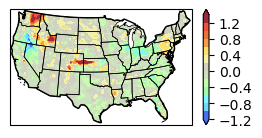

In [27]:
from   matplotlib.colors import ListedColormap
import cartopy.io.shapereader   as shpreader
import cartopy.feature   as     cfeature
import cartopy.crs       as     crs
from   matplotlib.colors import ListedColormap
from   netCDF4           import Dataset
import xarray            as     xr
from   wrf               import ( getvar, latlon_coords)
import numpy             as     np
# MY list of RGB colors --- for ACC
cmap_RGB_ACC      = [ ( 70, 111, 235),  (112, 214, 251),  (128, 245, 253), (158, 252, 175),
                      (199, 253, 173),  (205, 224, 191),  (209, 209, 194), (241, 241, 175),
                      (250, 224, 107),  (242, 160,  72),  (238, 112,  60), (237,  81,  55),
                      (154,  45,  61) ] 
levels_acc        = [-0.6,-0.5,-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7]
levels = [x*2 for x in levels_acc]

contour_plot(diff.sel(month =2)['T2MAX'],cmap_acc,levels)



In [ ]:

raw_init_dates = ['20231008','20231013','20231018','20231023','20231028','20231102','20231107','20231112','20231117','20231122','20231127','20231202','20231207','20231212','20231217','20231222','20231227','20240101','20240106','20240111','20240116','20240121','20240126','20240131','20240205','20240210','20240215']

for raw_init_date in raw_init_dates:
    command = f'scp umd-gwli@login.rockfish.jhu.edu:/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/CWRF_v0_adjustment/{raw_init_date}*T2MAX*  /mnt/gfs01/PUB/S2S/V2023-07/Operational/{raw_init_date}/'    
    subprocess.run(command, shell=True)
    command = f'scp umd-gwli@login.rockfish.jhu.edu:/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/CWRF_v0_adjustment/{raw_init_date}*T2MIN*  /mnt/gfs01/PUB/S2S/V2023-07/Operational/{raw_init_date}/'    
    subprocess.run(command, shell=True)



In [ ]:
scp  /mnt/gfs01/PUB/CFS/regrid_full_monthly/transfer/*   umd-gwli@login.rockfish.jhu.edu:/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/CFS/regrid_full_monthly/

In [11]:
# Move file from local
import subprocess
raw_init_dates = ['20231008','20231013','20231018','20231023','20231028','20231102','20231107','20231112','20231117','20231122','20231127','20231202','20231207','20231212','20231217','20231222','20231227','20240101','20240106','20240111','20240116','20240121','20240126','20240131','20240205','20240210','20240215']
for raw_init_date in raw_init_dates:
    command =f'mv /mnt/gfs01/PUB/S2S/V2023-07/Operational/local_data/{raw_init_date}*T2MAX*   /mnt/gfs01/PUB/S2S/V2023-07/Operational/{raw_init_date}/'
    subprocess.run(command, shell=True)
    command =f'mv /mnt/gfs01/PUB/S2S/V2023-07/Operational/local_data/{raw_init_date}*T2MIN*   /mnt/gfs01/PUB/S2S/V2023-07/Operational/{raw_init_date}/'
    subprocess.run(command, shell=True)

    

In [10]:
# Transfer from rockfish to dawn
import sys,os
import datetime
import subprocess


user_server    = 'guangwei@129.2.80.228'
raw_init_dates = ['20231008','20231013','20231018','20231023','20231028','20231102','20231107','20231112','20231117','20231122','20231127','20231202','20231207','20231212','20231217','20231222','20231227','20240101','20240106','20240111','20240116','20240121','20240126','20240131','20240205','20240210','20240215']


# for raw_init_date in raw_init_dates:
#     print(raw_init_date)
#     command =f'scp -P 2322 /mnt/gfs01/PUB/S2S/V2023-07/Operational/local_data/{raw_init_date}*T2MAX*   {user_server}:/mnt/gfs01/PUB/S2S/V2023-07/Operational/{raw_init_date}/'
#     subprocess.run(command, shell=True)
#     command =f'scp -P 2322  /mnt/gfs01/PUB/S2S/V2023-07/Operational/local_data/{raw_init_date}*T2MIN*   {user_server}:/mnt/gfs01/PUB/S2S/V2023-07/Operational/{raw_init_date}/'
#     subprocess.run(command, shell=True)
